# <center>Using neural networks to identify crystals from Raman spectroscopy data

Raman spectroscopy is an extremely useful technique used to identify molecules and crystals, because it is a quick, cheap and non-invasive probe. Indeed, Raman measurements have already become common place in the pharmaceutical industry for identifying the composition of tablets.

This notebook shows how machine learning can be used to identify materials from the 1D Raman spectra. The example data comes from the crystals ReS$_{2}$ and ReSe$_{2}$. These crystals were measured on their own and in comebination with our materials such as SiO$_{2}$ and graphite.

### Import modules

In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

### Create directories and copy in data

In [2]:
def folder_creater(folder, directory, SPLIT_SIZE = 0.8):
    
    parent_dir = os.getcwd()
    path = os.path.join(parent_dir, directory)

    # Empty directory to prevent FileExistsError is the function is run several times
    if os.path.exists(path):
      shutil.rmtree(path)
    
    # Create top directory
    os.makedirs(path)
    path = os.path.join(parent_dir, directory)
    
    # Find name of labels for folder names
    path_images = parent_dir + '/' + folder
    _tmp = os.listdir(path_images)
    _tmp.remove('.DS_Store')
    
    # Create the training and validation subdirectories
    training = os.path.join(path, 'training')
    os.makedirs(training)
    if os.path.exists(os.path.join(training, '.DS_Store')):
        os.remove(os.path.join(training, '.DS_Store'))
        
    validation = os.path.join(path, 'validation')
    os.makedirs(validation)
    if os.path.exists(os.path.join(validation, '.DS_Store')):
        os.remove(os.path.join(validation, '.DS_Store'))

    # Loop over all different labels
    for i in range(len(_tmp)):
        
        # Create subdirectories with name of labels in training
        # and validation folders
        new_train = os.path.join(training, _tmp[i])
        os.makedirs(new_train)
        new_validation = os.path.join(validation, _tmp[i])
        os.makedirs(new_validation)
        
        # Find names of image files
        _sub_folder = os.path.join(path_images, _tmp[i])
        _files = os.listdir(_sub_folder)
        if '.DS_Store' in _files:
            _files.remove('.DS_Store')
        
        # Shuffle the files
        random.sample(_files, len(_files))
        
        # Split into training and validation sets
        _train = _files[:int(SPLIT_SIZE*len(_files))]
        _validation = _files[int(SPLIT_SIZE*len(_files)):]
        
        # Copy files from original folders to new directories that
        # have been created for use with ImageGenerator
        for _file in _train:
            copyfile(_sub_folder + '/' + _file, new_train + '/' + _file)
        for _file in _validation:
            copyfile(_sub_folder + '/' + _file, new_validation + '/' + _file)
        
        # Check that the number of images matches the expected output
        print(f"\n\nThere are {len(os.listdir(new_train))} images of {_tmp[i]} for training")
        print(f"There are {len(os.listdir(new_validation))} images of {_tmp[i]} for validation")
        
    return training, validation

folder="data"
directory = "Raman"

TRAIN_DIR, VALIDATION_DIR = folder_creater(folder,directory)



There are 67 images of ReS2 for training
There are 17 images of ReS2 for validation


There are 72 images of ReSe2 for training
There are 18 images of ReSe2 for validation


In [3]:
# Check the folders have been created succcessfully

parent_dir = os.getcwd()
directory = "Raman"

path = os.path.join(parent_dir, directory)

for rootdir, dirs, files in os.walk(path):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/Users/lewishart/LinkedInLearning/Tensor_flow/Raman/Raman/training
/Users/lewishart/LinkedInLearning/Tensor_flow/Raman/Raman/validation
/Users/lewishart/LinkedInLearning/Tensor_flow/Raman/Raman/training/ReS2
/Users/lewishart/LinkedInLearning/Tensor_flow/Raman/Raman/training/ReSe2
/Users/lewishart/LinkedInLearning/Tensor_flow/Raman/Raman/validation/ReS2
/Users/lewishart/LinkedInLearning/Tensor_flow/Raman/Raman/validation/ReSe2


### Display graphs

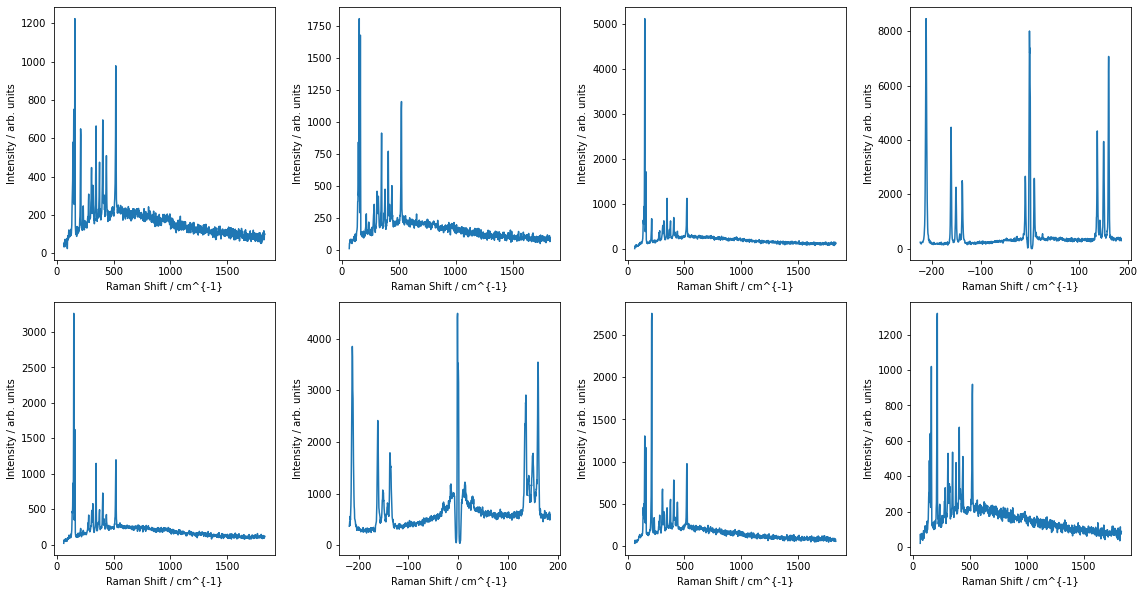

In [26]:
def Graph_display(crystal, number = 8):
    '''
    A function to visualize the Raman spectra
    Parameters:
        Crystal - Type of material the Raman spectra belongs to
        number - Number of spectra to display
    '''
    # Index for iterating over images
    pic_index = 0

    # Directory containing the data
    dire = os.path.join(parent_dir, 'Raman/training/'+crystal)

    # Filenames
    name = os.listdir(dire)
    names = name[:number]

    # Parameters for our graph; we'll output images in a 4x4 configuration
    nrows = int(len(names)/4) + 1
    ncols = 4

    # Set up matplotlib fig, and size it to fit 4x4 pics
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    # Create a list of all filenames
    pix = [os.path.join(dire, fname) for fname in names]

    for i, img_path in enumerate(pix):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        
        # Load Raman spectra skipping the first row which contains labels
        img = np.loadtxt(img_path, skiprows=1)
        
        # Plot Raman spectra
        plt.plot(img[:,0],img[:,1])
        plt.xlabel('Raman Shift / cm^{-1}')
        plt.ylabel('Intensity / arb. units')
        plt.tight_layout()

    plt.show()

# Visualize ReS2 Raman spectra
Graph_display(crystal='ReS2')

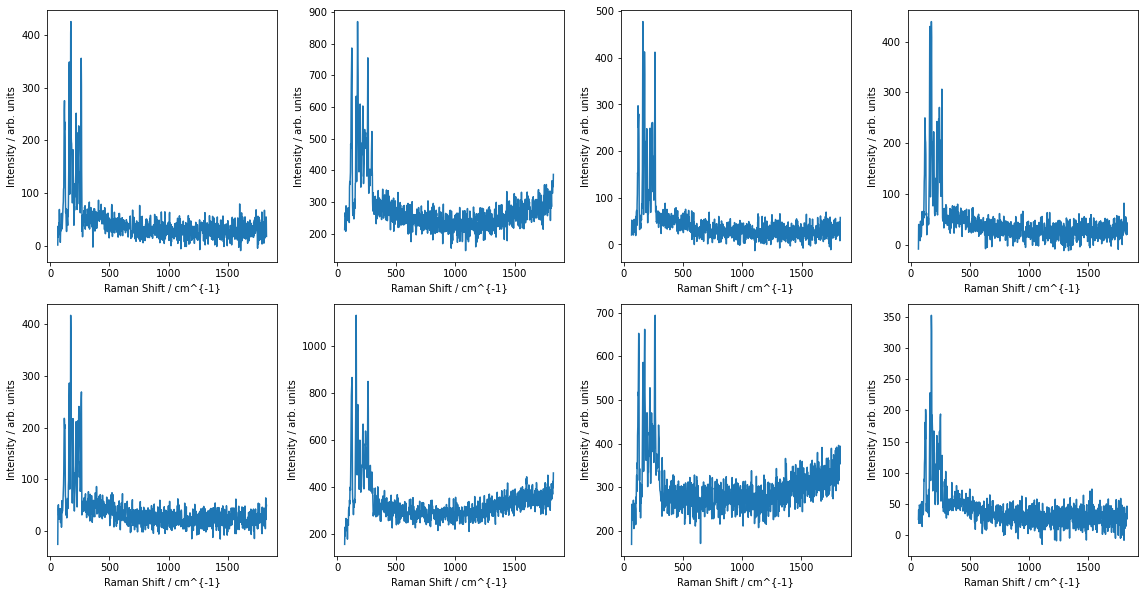

In [27]:
# Visualize ReS2 Raman spectra
Graph_display(crystal='ReSe2')

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    '''
    Generates data for Keras from the folders structure previously defined
    '''
    def __init__(self, path, batch_size=32, dim=(1000,2), n_channels=1,
                 shuffle=True, training=True):
        # Dimension of the Raman spectra
        self.dim = dim
        
        # Batch size, default = 32
        self.batch_size = batch_size
        
        # Path to the directory containing the Raman spectra
        if training:
            self.path = path + '/training'
        else:
            self.path = path + '/validation'
            
        # Need to read the location of all files and the name of the folder for labels
        # Create containers for filename list, a list of labels
        self.list_IDs = []
        _labels_cont = []
        
        # Identify all labels
        labels = os.listdir(self.path)
        
        # Create a dictionary with keys: labels and an identifying number
        self.labels_dic = dict(zip(labels,range(len(labels))))
        
        for label in labels:
            # folder containing all files of a label
            _file_path = os.path.join(self.path, label)
            
            # All the filenames corresponding to a label
            _file = os.listdir(_file_path)
            
            # Add filenames to a list
            self.list_IDs.extend(_file)
            
            # list that is the length of the number of files all containing the label
            _labels_cont.extend(np.full(len(_file),label))
        
        # Dictionary with keys: filename and label
        self.labels = dict(zip(self.list_IDs,_labels_cont))
        
        # Number of channels
        self.n_channels = n_channels
        
        # Reorder list of files
        self.shuffle = shuffle
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.loadtxt(os.path.join(os.path.join(self.path, self.labels[ID]),ID), skiprows=1, max_rows=1000)

            # Store label
            y[i] = self.labels_dic[self.labels[ID]]
            
        return X, y #tf.keras.utils.to_categorical(y, num_classes=len(self.labels_dic))
    
# Parameters
params = {'dim': (1000,2),
          'batch_size': 32,
          'n_channels': 1,
          'shuffle': True}

path = os.path.join(parent_dir, 'Raman')

# Generators
training_generator = DataGenerator(path, training=True, **params)
validation_generator = DataGenerator(path, training=False, **params)

### Get an idea of a good learning rate

In [7]:
def adjust_learning_rate(dataset):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(16, (3), activation='relu', input_shape=(1000, 2)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(32, (3), activation='relu'),
        tf.keras.layers.MaxPooling1D(2), 
        tf.keras.layers.Conv1D(64, (3), activation='relu'), 
        tf.keras.layers.MaxPooling1D(2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(units = 512, activation='relu'), 
        # Only 1 output neuron. It will contain a value from 0-1
        # where 0 for 1 class ('ReS2') and 1 for the other ('ReSe2')
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    
    model.summary()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 4))
    
    model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    
    history = model.fit(training_generator, epochs=20, callbacks=[lr_schedule])
    
    return history

In [8]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(training_generator)

2022-11-04 13:16:41.752084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-04 13:16:41.752688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 16)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 64)           6208      
                                                                 
 max_pooling1d_2 (MaxPooli

2022-11-04 13:16:43.025240: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-04 13:16:43.345865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 5s 48ms/step - loss: 144.1212 - accuracy: 0.4844 - lr: 1.0000e-04
Epoch 2/20
4/4 [==============================] - 0s 53ms/step - loss: 125.1016 - accuracy: 0.5938 - lr: 1.7783e-04
Epoch 3/20
4/4 [==============================] - 0s 52ms/step - loss: 133.0044 - accuracy: 0.5312 - lr: 3.1623e-04
Epoch 4/20
4/4 [==============================] - 0s 51ms/step - loss: 82.5362 - accuracy: 0.6797 - lr: 5.6234e-04
Epoch 5/20
4/4 [==============================] - 0s 51ms/step - loss: 28.4423 - accuracy: 0.7578 - lr: 0.0010
Epoch 6/20
4/4 [==============================] - 0s 51ms/step - loss: 14.8835 - accuracy: 0.9219 - lr: 0.0018
Epoch 7/20
4/4 [==============================] - 0s 50ms/step - loss: 1.8269 - accuracy: 0.9844 - lr: 0.0032
Epoch 8/20
4/4 [==============================] - 0s 51ms/step - loss: 216.2652 - accuracy: 0.8125 - lr: 0.0056
Epoch 9/20
4/4 [==============================] - 0s 51ms/step - loss: 52.4927 - accuracy: 0.8594 - lr: 

(0.0001, 10.0, 0.0, 1000.0)

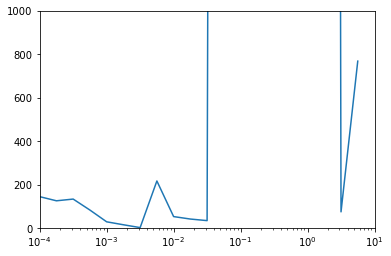

In [18]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 1000])

### Vary parameters to find best model

The number of dropout units is varied to identify the best model that limits overfitting.

In [10]:
def model_builder(hp):

    hp_units = hp.Float('units', min_value=0.0, max_value=0.3, step=0.1)
    
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv1D(16, (3), activation='relu', input_shape=(1000,2)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(32, (3), activation='relu'),
        tf.keras.layers.MaxPooling1D(2), 
        tf.keras.layers.Conv1D(64, (3), activation='relu'), 
        tf.keras.layers.MaxPooling1D(2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(hp_units),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid')  
    ])
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    
    return(model)

tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     directory='my_dir4',
                     project_name='Raman')

#Stop the training if the validation loss does not improve after epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tensor_board = tf.keras.callbacks.TensorBoard()

tuner.search(training_generator, epochs=50, validation_data = validation_generator, callbacks=[stop_early, tensor_board])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project my_dir4/Raman/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir4/Raman/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [11]:
print(f"""
The hyperparameter search is complete. The optimal number of dropout units in the first densely-connected
layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of dropout units in the first densely-connected
layer is 0.2.



### Build the model using the best parameters found earlier

In [12]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

model_weights = os.path.join(os.getcwd(), 'model_weights')

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(model_weights):
    shutil.rmtree(model_weights)

os.makedirs(model_weights)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_weights,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

history = model.fit(
            training_generator,
            epochs=10,
            validation_data=validation_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/10


2022-11-04 13:16:53.570874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/4 [=====================>........] - ETA: 0s - loss: 920.4976 - accuracy: 0.4375
Epoch 1: val_loss improved from inf to 97.55345, saving model to /Users/lewishart/LinkedInLearning/Tensor_flow/Raman/model_weights


2022-11-04 13:16:54.296503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 214ms/step - loss: 839.9468 - accuracy: 0.4297 - val_loss: 97.5535 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 59.8509 - accuracy: 0.5391
Epoch 2: val_loss improved from 97.55345 to 23.16003, saving model to /Users/lewishart/LinkedInLearning/Tensor_flow/Raman/model_weights
4/4 [==============================] - 0s 142ms/step - loss: 59.8509 - accuracy: 0.5391 - val_loss: 23.1600 - val_accuracy: 0.5312
Epoch 3/10
3/4 [=====================>........] - ETA: 0s - loss: 17.0456 - accuracy: 0.6146
Epoch 3: val_loss improved from 23.16003 to 2.49795, saving model to /Users/lewishart/LinkedInLearning/Tensor_flow/Raman/model_weights
4/4 [==============================] - 0s 139ms/step - loss: 18.7605 - accuracy: 0.5781 - val_loss: 2.4980 - val_accuracy: 0.6875
Epoch 4/10
3/4 [=====================>........] - ETA: 0s - loss: 6.9333 - accuracy: 0.7188
Epoch 4: val_loss improved from 2.49795 to 1.00331, saving

### Visualize accuracy and loss as a function of epoch

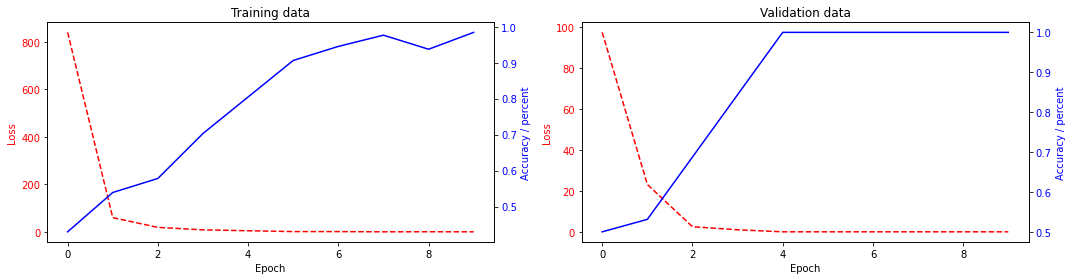

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Visualize loss  and accuracy history
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,4))
ax2 = ax[0].twinx()
ax[0].plot(history.history['loss'], 'r--',)
ax2.plot(history.history['accuracy'], 'b-')
ax[0].set_xlabel('Epoch')
ax[0].tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Accuracy / percent',c='b')
ax[0].set_ylabel('Loss', c='r')
ax2.tick_params(axis='y', labelcolor='b')
ax[0].set_title('Training data')

ax3 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], 'r--',)
ax3.plot(history.history['val_accuracy'], 'b-')
ax[1].set_xlabel('Epoch')
ax[1].tick_params(axis='y', labelcolor='r')
ax3.tick_params(axis='y', labelcolor='b')
ax3.set_ylabel('Accuracy / percent',c='b')
ax[1].set_ylabel('Loss', c='r')
ax[1].set_title('Validation data')
plt.tight_layout()

### Evaluate the model

In [14]:
# Create a basic model instance
model_best = tuner.hypermodel.build(best_hps)

# Loads the weights
model_best.load_weights(model_weights)

# Evaluate the model
loss, acc = model_best.evaluate(validation_generator, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

1/1 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - 261ms/epoch - 261ms/step
Trained model, accuracy: 100.00%


2022-11-04 13:16:59.185926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Test the model

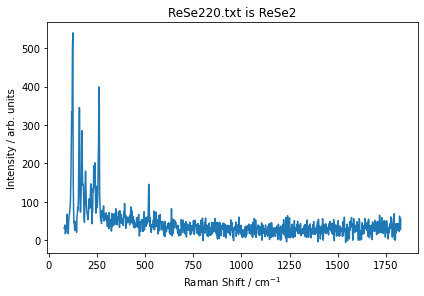

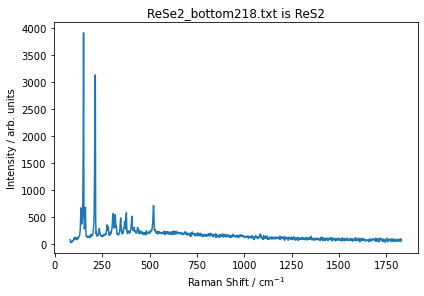

In [20]:
import numpy as np

test_dir = os.path.join(os.getcwd(), 'test_images')
test_files = os.listdir(test_dir)
test_files.remove('.DS_Store')

for fn in test_files:
    # predicting images
    t = test_dir + '/' + fn
    img=np.loadtxt(t, skiprows=1, max_rows=1000)

    x=np.expand_dims(img, axis=0)
    images = np.vstack([x])

    classes = model_best.predict(images, batch_size=1, verbose=3)
    plt.figure()
    plt.plot(img[:,0],img[:,1])
    plt.xlabel('Raman Shift / cm$^{-1}$')
    plt.ylabel('Intensity / arb. units')
    plt.tight_layout()

    if classes[0]>0.5:
        plt.title(fn + " is ReSe2")
    else:
        plt.title(fn + " is ReS2")

### Conclusions

This model is able to determine whether Raman spectra belongs to ReS$_{2}$ or ReSe$_{2}$, even when other compounds are measured at the same time. This is a simple model and the next steps will be to expand this a multiclass problem where multiple compounds can be identified.